In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import itertools
import json
import random
import nibabel as nb
import pystan
import scipy
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df_hqn = pd.read_csv('/home/abhijit/Jyotirmay/thesis/my_thesis/projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v5-nobn/KORA/10_1566495633.0629191_report.csv')
df_hqn.loc[0] = None
df_hqn.dropna(inplace=True)

In [3]:
df = pd.read_csv('./dataset_groups/whole_body_datasets/KORA/KORA-diabetes-english.csv')
df.head(5).transpose().head(20).to_html('df.html')


In [4]:
df.head(5).transpose().head(100).to_html('df_1.html')

In [6]:

df.dropna(inplace=True)
# -1: 'nan', 0: 'normal', 1: 'pre-diabetes', 2: 'type-2-diabetes', 3: 'type-1-diabetes'
df.diabetes_status = pd.factorize(df.diabetes_status)[0]
# df[df.diabetes_status == -1] = None
# 0= Female, 1= Male
df.sex = pd.get_dummies(df[['sex']], drop_first=True)
#  -1: 'nan', 0: 'no', 1: 'yes']
df['mri-liver-fat-artifacts'] = pd.factorize(df['mri-liver-fat-artifacts'])[0]

df['meds-insulin-therapy'] = pd.factorize(df['meds-insulin-therapy'])[0]
df['hypertension'] = pd.factorize(df['hypertension'])[0]
df['meds-antidiabetic'] = pd.factorize(df['meds-antidiabetic'])[0]
df['meds-antihypertensive'] = pd.factorize(df['meds-antihypertensive'])[0]
df['meds-lipoprotein-lowering'] = pd.factorize(df['meds-lipoprotein-lowering'])[0]
df['meds-oral-antidiabetic'] = pd.factorize(df['meds-oral-antidiabetic'])[0]
df['meds-incretin-mimetics'] = pd.factorize(df['meds-incretin-mimetics'])[0]

# 0: 'regular', 1: 'former', 2: 'non-smoker', 3: 'irregular'
df.smoker = pd.factorize(df.smoker)[0]
# 0: 'normal', 1: 'pre-obisety', 2: 'obesity class I', 3: 'obesity class II',
# 4: 'obesity class III', 5: 'underweight'
df['bmi-who'] = pd.factorize(df['bmi-who'])[0]


In [7]:
base_dir = '/home/abhijit/Jyotirmay/thesis/my_thesis/projects/hierarchical_quicknat/outs/hierarchical_quicknat_KORA_v5-nobn/hierarchical_quicknat_KORA_v5-nobn_predictions_KORA/'
for idx, dd in df_hqn.iterrows():
    for i in range(10):
        sample_path = base_dir + dd['volume_id']+'_samples/'+dd['volume_id']+'_sample_'+str(i)+'.nii.gz'
        niifile = nb.load(sample_path)
        data = niifile.get_fdata()
        unique, counts = np.unique(data, return_counts=True)
        df_hqn.at[idx, f'sample_{i}_liver_volume'] = counts[2]
        df_hqn.at[idx, f'sample_{i}_spleen_volume'] = counts[1]
        
    seg_path = base_dir + dd['volume_id']+'_seg.nii.gz'    
    niifile = nb.load(seg_path)
    data = niifile.get_fdata()
    unique, counts = np.unique(data, return_counts=True)
    df_hqn.at[idx, 'liver_volume'] = counts[2]
    df_hqn.at[idx, 'spleen_volume'] = counts[1]

In [8]:
for idx, dd in df_hqn.iterrows():
    print(dd)
    break
    

project                                                            1
dataset                                                            0
model_name                        hierarchical_quicknat_KORA_v5-nobn
volume_id                                                KORA2458197
samples                                                           10
sncc                                                       0.0261442
ged                                                          0.11287
iou_spleen                                                  0.980301
iou_liver                                                   0.982447
iou_mean                                                    0.981374
dice_spleen                                                 0.944901
dice_liver                                                  0.963225
dice_mean                                                   0.954063
surface_distance_prtogt_spleen                              0.910885
surface_distance_prtogt_liver     

In [9]:
get_id = lambda x: x[4:]
df_hqn.volume_id = df_hqn.volume_id.apply(get_id)

In [10]:
# df_hqn
df['mrt-image-id'] = df['mrt-image-id'].astype(str)
df_hqn.volume_id = df_hqn.volume_id.astype(str)
df_merge_difkey = pd.merge(df, df_hqn, left_on='mrt-image-id', right_on='volume_id')

df_merge_difkey.head()

,age,alcohol-g/day,blood-pressure-diastolic,blood-pressure-systolic,bmi-numeric,bmi-who,cholesterol-hdl,cholesterol-ldl,cholesterol-total,diabetes_status,...,sample_6_liver_volume,sample_6_spleen_volume,sample_7_liver_volume,sample_7_spleen_volume,sample_8_liver_volume,sample_8_spleen_volume,sample_9_liver_volume,sample_9_spleen_volume,liver_volume,spleen_volume
0,54,24.14,91.5,142.0,26.95,1,60.00,172,250,0,...,76209.0,7283.0,76202.0,7261.0,76159.0,7272.0,76196.0,7293.0,76221.0,7274.0
1,66,5.71,77.0,126.5,25.75,1,49.00,167,218,0,...,92607.0,17125.0,92556.0,17117.0,92545.0,17108.0,92572.0,17108.0,92541.0,17105.0
2,66,0.00,80.0,121.5,29.01,1,65.00,185,261,0,...,68841.0,9332.0,68729.0,9322.0,68749.0,9301.0,68743.0,9336.0,68756.0,9325.0
3,42,0.00,78.5,129.0,31.25,2,62.88,160,232,1,...,88567.0,12102.0,88665.0,12071.0,88607.0,12108.0,88664.0,12062.0,88558.0,12091.0
4,62,1.57,89.0,125.0,30.55,2,78.00,185,275,0,...,60513.0,8415.0,60632.0,8399.0,60575.0,8427.0,60558.0,8420.0,60554.0,8415.0


In [11]:
df_merge_difkey.columns

Index(['age', 'alcohol-g/day', 'blood-pressure-diastolic',
       'blood-pressure-systolic', 'bmi-numeric', 'bmi-who', 'cholesterol-hdl',
       'cholesterol-ldl', 'cholesterol-total', 'diabetes_status',
       'hba1c-mmol/mol', 'hba1c-percentage', 'height', 'hypertension',
       'meds-antidiabetic', 'meds-antihypertensive', 'meds-incretin-mimetics',
       'meds-insulin-therapy', 'meds-lipoprotein-lowering',
       'meds-oral-antidiabetic', 'mri-liver-fat-artifacts',
       'mri-liver-fat-lobus-dexter', 'mri-liver-fat-lobus-sinister',
       'mri-liver-fat-portal-vein', 'mrt-image-id', 'sex', 'smoker',
       'smoking-packages', 'triglyceride', 'weight', 'project', 'dataset',
       'model_name', 'volume_id', 'samples', 'sncc', 'ged', 'iou_spleen',
       'iou_liver', 'iou_mean', 'dice_spleen', 'dice_liver', 'dice_mean',
       'surface_distance_prtogt_spleen', 'surface_distance_prtogt_liver',
       'surface_distance_prtogt_mean', 'surface_distance_gttopr_spleen',
       'surface_di

In [12]:
schools_code = """
data {
  int<lower=1> D; // Dimension of data 4
  int<lower=0> N; // Number of samples (Num of Patients * MC samples)
  real y[N]; // volume estimates
  row_vector[D] x[N]; //
}

parameters {
  real mu[D];
  real<lower=0> sigma[D];
  real<lower=0> global_sigma;
  vector[D] beta;
}

model {
  for (d in 1:D) {
    mu[d] ~ normal(0, 100);
    beta[d] ~ normal(mu[d], sigma[d]);
  }
  for (n in 1:N)
    y[n] ~ normal(x[n] * beta, global_sigma);
}
"""

sm = pystan.StanModel(model_code=schools_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cf0bad18dd10bfaad7121b50f010cda6 NOW.


In [13]:
y = df_merge_difkey['diabetes_status'].values
# sex = df_merge_difkey['sex'].values
# age = df_merge_difkey['age'].values
# bmi = df_merge_difkey['bmi-numeric'].values
# vol = df_merge_difkey['liver_volume'].values
x = df_merge_difkey[['liver_volume', 'age','bmi-numeric']].values


In [14]:
schools_dat = {'D': 3,
               'N': len(y),
               'x': x,
               'y': y}

In [15]:

fit = sm.sampling(data=schools_dat, iter=25000, chains=4, verbose=True)

In [16]:
print(fit)

Inference for Stan model: anon_model_cf0bad18dd10bfaad7121b50f010cda6.
4 chains, each with iter=25000; warmup=12500; thin=1; 
post-warmup draws per chain=12500, total post-warmup draws=50000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]         -5.02    4.27   18.3 -51.19 -11.27  -0.02   5.04  23.63     18   1.24
mu[2]         -0.61    5.06   8.76 -18.47  -7.27   1.47    4.2  16.33      3   2.37
mu[3]        -19.18   28.63  45.02 -136.3 -12.76   1.14   8.41  23.31      2   3.25
sigma[1]     9.8e42  9.0e42 7.8e44   5.58 296.19  5.3e4  1.3e8 2.2e35   7515    1.0
sigma[2]     2.2e15  2.2e15 2.6e16   1.49 185.12 3326.8  7.0e5 1.9e15    137   1.03
sigma[3]     3.3e38  3.0e38 1.5e40   2.64 261.13  1.9e5 3.8e11 5.4e34   2366    1.0
global_sigma   0.66  7.4e-4   0.04   0.59   0.63   0.66   0.68   0.74   2800    1.0
beta[1]      3.8e-6  5.4e-8 3.1e-6-2.2e-6 1.8e-6 3.8e-6 5.9e-6 9.8e-6   3300    1.0
beta[2]     -1.5e-3  1.1e-4 4.5e-3  -0.01-4.4e-3-1.

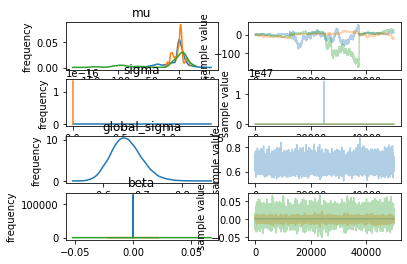

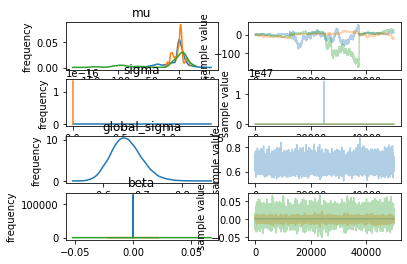

In [17]:
fit.plot()

In [ ]:
# feats = ['age', 'alcohol-g/day', 'blood-pressure-diastolic',
#        'blood-pressure-systolic', 'bmi-numeric', 'cholesterol-hdl',
#        'cholesterol-ldl', 'cholesterol-total', 'hypertension', 'mri-liver-fat-artifacts',
#        'mri-liver-fat-lobus-dexter', 'mri-liver-fat-lobus-sinister',
#        'mri-liver-fat-portal-vein', 'sex',
#        'smoking-packages', 'triglyceride', 'iou_spleen',
#        'iou_liver',  'dice_spleen', 'dice_liver',
#        'surface_distance_prtogt_spleen', 'surface_distance_prtogt_liver', 'surface_distance_gttopr_spleen',
#        'surface_distance_gttopr_liver', 'liver_volume', 'spleen_volume']

# feats = ['age', 'bmi-numeric',  'sex', 'iou_spleen',
#        'iou_liver', 'liver_volume', 'spleen_volume']

# # ('age',) 0.6071428571428571
# # ('blood-pressure-systolic',) 0.75
# # ('blood-pressure-systolic', 'triglyceride') 0.7857142857142857
# # ('blood-pressure-systolic', 'hba1c-mmol/mol') 0.8214285714285714
# # ('triglyceride', 'hba1c-mmol/mol') 0.8571428571428571
# # ('mri-liver-fat-lobus-sinister', 'meds-antihypertensive') 0.8928571428571429
# # ('age', 'blood-pressure-systolic', 'triglyceride', 'mri-liver-fat-lobus-dexter') 0.9285714285714286
# # ('blood-pressure-systolic', 'triglyceride', 'alcohol-g/day', 'weight') 0.9642857142857143
# # ('blood-pressure-systolic', 'triglyceride', 'alcohol-g/day', 'mri-liver-fat-lobus-sinister', 'blood-pressure-diastolic') 1.0

# random.shuffle(feats)
# print(feats)

In [ ]:
# data = df_merge_difkey.copy()
# y = data["diabetes_status"].copy()
# y[y == 3] = None
# y.dropna(inplace=True)
# y_classes = np.argmax(pd.get_dummies(y).values, axis=1)

# # X = pd.get_dummies(data.loc[y.index, list(feats)], drop_first=True)
# # model = LogisticRegression(multi_class="multinomial", solver="lbfgs").fit(X, y_classes)
# # c_score = model.score(X, y_classes)
# # print(c_score)

# # best = 0
# # max_score = {}
# # for L in range(1, len(feats)+1):
# #     for subset in itertools.combinations(feats, L):
# # #         print(subset)
# #         X = pd.get_dummies(data.loc[y.index, list(subset)], drop_first=True)
# #         model = LogisticRegression(multi_class="multinomial", solver="lbfgs").fit(X, y_classes)
# #         c_score = model.score(X, y_classes)
# #         max_score[c_score] = subset
# #         if c_score>best:
# #             best = c_score
# #             print(subset, c_score)

# # with open('c_model_out_merged.txt', 'w+') as f:
# #     f.write(json.dumps(max_score, indent=4))